In [1]:
import numpy as np
import torch
import torch.nn as nn
import pickle
import pandas as pd

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
from clearml import Task
import torch.optim as optim

from utils.models import CNN, MLP, DeepCNN
from utils.train_val_test import train_epoch, test, display_losses
from utils.dataset import MatricesDataset


In [2]:
config = {
    'dataset':{
        'target_name': 'h31',
        'class_label': 'original',
        'capacity': 'full',
        'test_size': 0.3,
        'train_batch': 2048,
        'validation_batch': 2048,
        'test_batch': 2048,
    },
    'model':{
        'device': 'cuda',
        'name': 'CNN'
    },
    'train':{
        'num_epochs': 30,
        'learning_rate': 5e-3,
        'weight_decay': 1e-5,
    }
}

In [3]:
task = Task.init(project_name="cicy4folds", task_name=f"{config['dataset']['target_name']}_{config['model']['name']}_train")
task.connect(config, name='Train config')

ClearML Task: created new task id=0cb742bd44d84d348205bfaa95519b05
2024-07-01 18:24:37,782 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/2e3a3c9f3a5d425f9af1864b8e2658f7/experiments/0cb742bd44d84d348205bfaa95519b05/output/log


{'dataset': {'target_name': 'h31',
  'class_label': 'original',
  'capacity': 'full',
  'test_size': 0.3,
  'train_batch': 2048,
  'validation_batch': 2048,
  'test_batch': 2048},
 'model': {'device': 'cuda', 'name': 'CNN'},
 'train': {'num_epochs': 30, 'learning_rate': 0.005, 'weight_decay': 1e-05}}

# Dataset

In [4]:
with open('data/padded_matrices', 'rb') as f:
    matrices = pickle.load(f)

df = pd.read_csv('data/cicy4folds_extended.csv')
df = df.replace('Null', np.nan)
nan_indeces = df.index[df.isna().any(axis=1)].tolist()

df_clear = df.drop(nan_indeces)
matrices_clear = np.delete(matrices, nan_indeces, axis=0)

assert len(df_clear)==len(matrices_clear)

In [5]:
df_train, df_test_validate, matrices_train, matrices_test_validate = train_test_split(df_clear, matrices_clear, test_size=config['dataset']['test_size'], shuffle=True)
df_test, df_validate, matrices_test, matrices_validate = train_test_split(df_test_validate, matrices_test_validate, test_size=config['dataset']['test_size'], shuffle=True)

In [6]:
train_ds = MatricesDataset(df_train, matrices_train, config['dataset']['target_name'])
validate_ds = MatricesDataset(df_validate, matrices_validate, config['dataset']['target_name'])
test_ds = MatricesDataset(df_test, matrices_test, config['dataset']['target_name'])

train_dataloader = DataLoader(train_ds, batch_size=config['dataset']['train_batch'], num_workers=4)
test_dataloader = DataLoader(test_ds, batch_size=config['dataset']['test_batch'], num_workers=4)
validate_dataloader = DataLoader(validate_ds, batch_size=config['dataset']['validation_batch'], num_workers=4)

# Model

In [7]:
if (config['model']['name']=='CNN'):
    model = CNN().to(config['model']['device'])
elif (config['model']['name']=='MLP'):
    #model = MLP(model_config).to(config['model']['device'])
    pass
elif (config['model']['name']=='DeepCNN'):
    model = DeepCNN().to(config['model']['device'])
else:
    raise NameError(f"There isn't model with name {config['model']['name']}")

criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=config['train']['learning_rate'], weight_decay=config['train']['weight_decay'])

In [7]:
try:
    model.load_state_dict(torch.load(f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth"))
    print('<All keys matched successfully>')
except:
    print("There isn't weights")

<All keys matched successfully>


In [8]:
train_loss = []
val_loss = []
min_val_loss = np.inf
for epoch in tqdm(range(config['train']['num_epochs'])):
    losses = train_epoch(model, optimizer, criterion, train_dataloader, validate_dataloader, config)
    print(f"{epoch+1}: loss on train: {losses['train_loss']:.4f}, loss on validation: {losses['validation_loss']:.4f}")
    train_loss.append(losses['train_loss'])
    val_loss.append(losses['validation_loss'])
    if(losses['validation_loss'] < min_val_loss):
        min_val_loss = losses['validation_loss']
        torch.save(model.state_dict(), f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth")

    task.get_logger().report_scalar(title="Loss", series="train loss", iteration=(epoch+1), value=losses['train_loss'])
    task.get_logger().report_scalar(title="Loss", series="validation loss", iteration=(epoch+1), value=losses['validation_loss'])

  0%|          | 0/30 [00:00<?, ?it/s]

1: loss on train: 185.9107, loss on validation: 131.7812
2024-07-01 18:26:10,249 - clearml.frameworks - INFO - Found existing registered model id=ddc782493a764b24978eac142d186465 [d:\Study\Skoltech\Master's thesis\cicy4folds_project\models\CNN_for_h31.pth] reusing it.


  3%|▎         | 1/30 [01:00<29:18, 60.64s/it]

2: loss on train: 110.2991, loss on validation: 83.3068


  7%|▋         | 2/30 [01:55<26:50, 57.50s/it]

3: loss on train: 85.1636, loss on validation: 67.4275


 10%|█         | 3/30 [02:52<25:38, 56.99s/it]

4: loss on train: 65.9374, loss on validation: 53.1829


 13%|█▎        | 4/30 [03:48<24:33, 56.66s/it]

5: loss on train: 55.5169, loss on validation: 45.2378


 17%|█▋        | 5/30 [04:44<23:26, 56.27s/it]

6: loss on train: 48.3964, loss on validation: 40.2686


 20%|██        | 6/30 [05:42<22:47, 56.97s/it]

7: loss on train: 43.2938, loss on validation: 36.6856


 23%|██▎       | 7/30 [06:39<21:47, 56.85s/it]

8: loss on train: 39.3692, loss on validation: 33.9458


 30%|███       | 9/30 [08:15<18:06, 51.73s/it]

9: loss on train: 36.5664, loss on validation: 36.0206
10: loss on train: 33.7701, loss on validation: 32.5509


 33%|███▎      | 10/30 [09:10<17:32, 52.62s/it]

11: loss on train: 31.5911, loss on validation: 31.6340


 37%|███▋      | 11/30 [10:04<16:49, 53.14s/it]

12: loss on train: 29.4380, loss on validation: 28.7493


 40%|████      | 12/30 [10:59<16:07, 53.73s/it]

13: loss on train: 27.9003, loss on validation: 27.6613


 43%|████▎     | 13/30 [11:53<15:14, 53.77s/it]

14: loss on train: 25.8502, loss on validation: 26.3678


 47%|████▋     | 14/30 [12:47<14:19, 53.74s/it]

15: loss on train: 24.2436, loss on validation: 23.5169


 53%|█████▎    | 16/30 [14:26<11:53, 50.97s/it]

16: loss on train: 22.8233, loss on validation: 24.0725
17: loss on train: 21.9852, loss on validation: 22.0625


 57%|█████▋    | 17/30 [15:23<11:24, 52.65s/it]

18: loss on train: 20.5386, loss on validation: 20.8769


 60%|██████    | 18/30 [16:19<10:44, 53.71s/it]

19: loss on train: 19.6373, loss on validation: 20.4218


 63%|██████▎   | 19/30 [17:15<10:00, 54.56s/it]

20: loss on train: 18.9114, loss on validation: 19.5967


 67%|██████▋   | 20/30 [18:11<09:09, 54.99s/it]

21: loss on train: 18.0407, loss on validation: 19.2086


 70%|███████   | 21/30 [19:08<08:18, 55.42s/it]

22: loss on train: 17.3690, loss on validation: 17.9474


 73%|███████▎  | 22/30 [20:05<07:27, 55.92s/it]

23: loss on train: 16.6912, loss on validation: 17.8397


 77%|███████▋  | 23/30 [21:02<06:33, 56.21s/it]

24: loss on train: 16.0838, loss on validation: 16.8085


 80%|████████  | 24/30 [21:59<05:38, 56.37s/it]

25: loss on train: 15.6434, loss on validation: 15.6092


 87%|████████▋ | 26/30 [23:48<03:40, 55.24s/it]

26: loss on train: 14.9947, loss on validation: 16.6585
27: loss on train: 14.6452, loss on validation: 15.0459


 93%|█████████▎| 28/30 [25:36<01:47, 53.59s/it]

28: loss on train: 14.1300, loss on validation: 15.4590
29: loss on train: 13.7914, loss on validation: 14.2871


100%|██████████| 30/30 [27:13<00:00, 54.44s/it]

30: loss on train: 13.1916, loss on validation: 15.6162


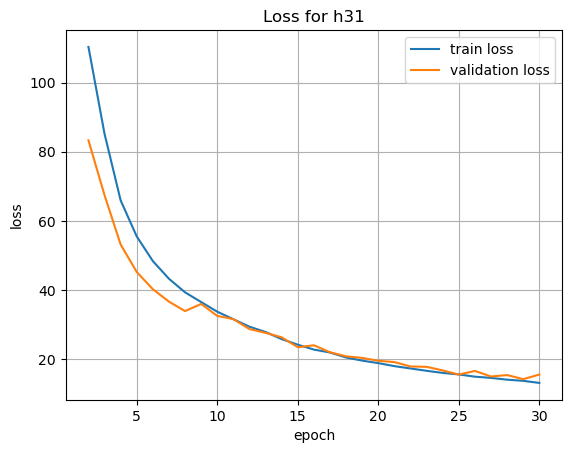

In [9]:
display_losses(train_loss, val_loss, config)

# Evaluation

In [10]:
model.load_state_dict(torch.load(f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth"))

<All keys matched successfully>

In [11]:
test_metrics = test(model, criterion, test_dataloader, config)
print(f"loss on test: {test_metrics['test_loss']:.3f}, accuracy on test: {test_metrics['test_accuracy']*100:.2f}%, mse on test: {test_metrics['test_mse']:.3f}")
test_metrics = pd.DataFrame(test_metrics, index=[f"{config['dataset']['target_name']}_{config['model']['name']}"])

100%|██████████| 93/93 [00:15<00:00,  6.03it/s]
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:2458: UserWarning:

y_pred contains classes not in y_true



loss on test: 14.094, accuracy on test: 16.81%, mse on test: 14.095


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [12]:
#new_dataframe_result = pd.DataFrame(columns=['h11', 'h21', 'h31', 'h22'], index=['CNN', 'MLP', 'DeepCNN'])
#dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")

In [13]:
dataframe_result = pd.read_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv", index_col=0)
dataframe_result[config['dataset']['target_name']][config['model']['name']] = round(test_metrics['test_accuracy'].item(),3)
dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")
dataframe_result

,h11,h21,h31,h22
CNN,0.852,0.648,0.168,0.033
MLP,0.033,0.640,0.028,0.002
DeepCNN,0.884,0.730,0.280,0.057


In [14]:
task.get_logger().report_table(title='Metrics table', series='pandas DataFrame', iteration=0, table_plot=test_metrics)

In [15]:
task.close()

# Some waste

In [9]:
batch = next(iter(test_dataloader))
model_out = model(batch['matrix'].to(config['model']['device'])).squeeze(-1)
ground_truth = batch['hodge_number'].to(config['model']['device'])

In [10]:
model_out[:14].round()

tensor([5., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [11]:
ground_truth[:14]

tensor([4., 0., 0., 2., 0., 0., 0., 3., 0., 0., 6., 1., 0., 0.],
       device='cuda:0')

In [12]:
(model_out.round()==ground_truth).sum().item(), len(ground_truth)

(660, 1024)